In [170]:
!pip install pandas nltk scikit-learn openai python-dotenv networkx matplotlib pydub elevenlabs

Using cached pydub-0.25.1-py2.py3-none-any.whl (32 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.5/116.5 kB 2.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 4.4 MB/s eta 0:00:00


In [182]:
import os
import openai
from openai import OpenAI
import networkx as nx
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import json
import pandas as pd
import numpy as np
from pydub import AudioSegment
from elevenlabs import play
from elevenlabs.client import ElevenLabs
from elevenlabs import save, Voice, VoiceSettings

In [172]:
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")
os.environ["OPENAI_API_KEY"] = openai_api_key

In [147]:
def chat(system_prompt, user_prompt = '', model = 'gpt-4o', temperature = 0, **kwargs):
    ''' This replies the user based on a system prompt and user prompt to call OpenAI Chat Completions API '''
    client = OpenAI()
    response = client.chat.completions.create(
        model=model,
        temperature = temperature,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ],
        **kwargs
    )
    res = response.choices[0].message.content
    return res

In [148]:
def build_knowledge_graph(transcript_summary):
    '''Extract knowledge graph from summarized text using schema'''
    completion = openai.chat.completions.create(
        model="gpt-4o",
        response_format={ "type": "json_object" },
        messages=[
            {"role": "system", "content": '''You are a knowledge graph builder, extract nodes and edges for a knowledge graph from the following text.
            You are to output relations between two objects in the form (object_1, relation, object_2). 
            All information about dates must be included.
            Make sure there are alwayd 3 elements in each tuple.
            Example Input: John bought a laptop
            Example Output: [('John', 'bought', 'laptop')]
            Example Input: John built a house in 2019
            Example Output: [('John', 'built', 'house'), ('house', 'built in', '2019')]
            The final output should be in JSON as follows, make sure the key is exactly: {"List of triplets": "List of triplets of the form (object_1, relation, object_2), type: list"}'''},
            {"role": "user", "content": f"Here's the text: {transcript_summary}"}
        ]
    )

    answer = json.loads(completion.choices[0].message.content) if completion.choices else "No response"

    return answer

In [149]:
def plot_graph(kg):
    ''' Plots graph based on knowledge graph '''
    # Create graph
    G = nx.DiGraph()
    G.add_edges_from((source, target, {'relation': relation}) for source, relation, target in kg['List of triplets'])

    # Plot the graph
    plt.figure(figsize=(10,6), dpi=300)
    pos = nx.spring_layout(G, k=3, seed=0)

    nx.draw_networkx_nodes(G, pos, node_size=1500)
    nx.draw_networkx_edges(G, pos, edge_color='gray')
    nx.draw_networkx_labels(G, pos, font_size=12)
    
    # Check if there are edge labels
    if nx.get_edge_attributes(G, 'relation'):
        edge_labels = nx.get_edge_attributes(G, 'relation')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

    # Display the plot
    plt.axis('off')
    plt.show()

In [150]:
# Function to merge new triplets into the existing knowledge graph
def merge_knowledge_graphs(existing_kg, new_kg):
    existing_triplets = set(tuple(triplet) for triplet in existing_kg['List of triplets'])
    new_triplets = set(tuple(triplet) for triplet in new_kg['List of triplets'])
    merged_triplets = existing_triplets.union(new_triplets)
    return {'List of triplets': list(merged_triplets)}

In [151]:
def parse_knowledge_graph(kg, question):
    '''Parse knowledge graph to extract relevant relations'''
    completion = openai.chat.completions.create(
        model="gpt-4o",
        response_format={ "type": "json_object" },
        messages=[
            {"role": "system", "content": f'''You are a knowledge graph parser for the following knowledge graph {kg}. 
            Only output the triplets that are relevant to the question.
            The final output should be in JSON as follows, make sure the key is exactly "List of triplets": {{"List of triplets": "List of triplets of the form (object1, relation, object2), type: list"}}'''},
            {"role": "user", "content": f"Here's the question: {question}"}
        ]
    )

    answer = json.loads(completion.choices[0].message.content) if completion.choices else "No response"

    return answer

In [152]:
# Initialize an empty knowledge graph or load from a saved state
existing_kg = {'List of triplets': []}

In [153]:
# Example of new input to be added to the knowledge graph
new_input = "Donald Trump can still run for president, but he might not be allowed to vote. The former president and presumptive 2024 Republican nominee was convicted of all 34 charges of falsifying business records by a Manhattan jury in his criminal hush money trial yesterday. The verdicts make Trump the first former commander-in-chief to be a convicted felon. Outside the courtroom, Trump told reporters, “I’m a very innocent man,” and repeatedly claimed the trial was “rigged.” He’ll be sentenced on July 11, just a few days before the Republican National Convention."

In [154]:
# Build knowledge graph from new input
new_kg = build_knowledge_graph(new_input)
print(new_kg)

{'List of triplets': [['Donald Trump', 'run for', 'president'], ['Donald Trump', 'might not be allowed to', 'vote'], ['Donald Trump', 'former', 'president'], ['Donald Trump', 'presumptive nominee of', '2024'], ['Donald Trump', 'nominee of', 'Republican Party'], ['Donald Trump', 'was convicted of', 'all 34 charges'], ['34 charges', 'involve', 'falsifying business records'], ['Manhattan jury', 'convicted', 'Donald Trump'], ['trial', 'occurred on', 'yesterday'], ['Donald Trump', 'verdicts make', 'first former commander-in-chief to be a convicted felon'], ['Donald Trump', 'told', 'reporters'], ['Donald Trump', 'claimed', "trial was 'rigged'"], ['Donald Trump', 'sentenced on', 'July 11'], ['July 11', 'is before', 'Republican National Convention']]}


In [155]:
# Merge the new knowledge graph into the existing one
merged_kg = merge_knowledge_graphs(existing_kg, new_kg)

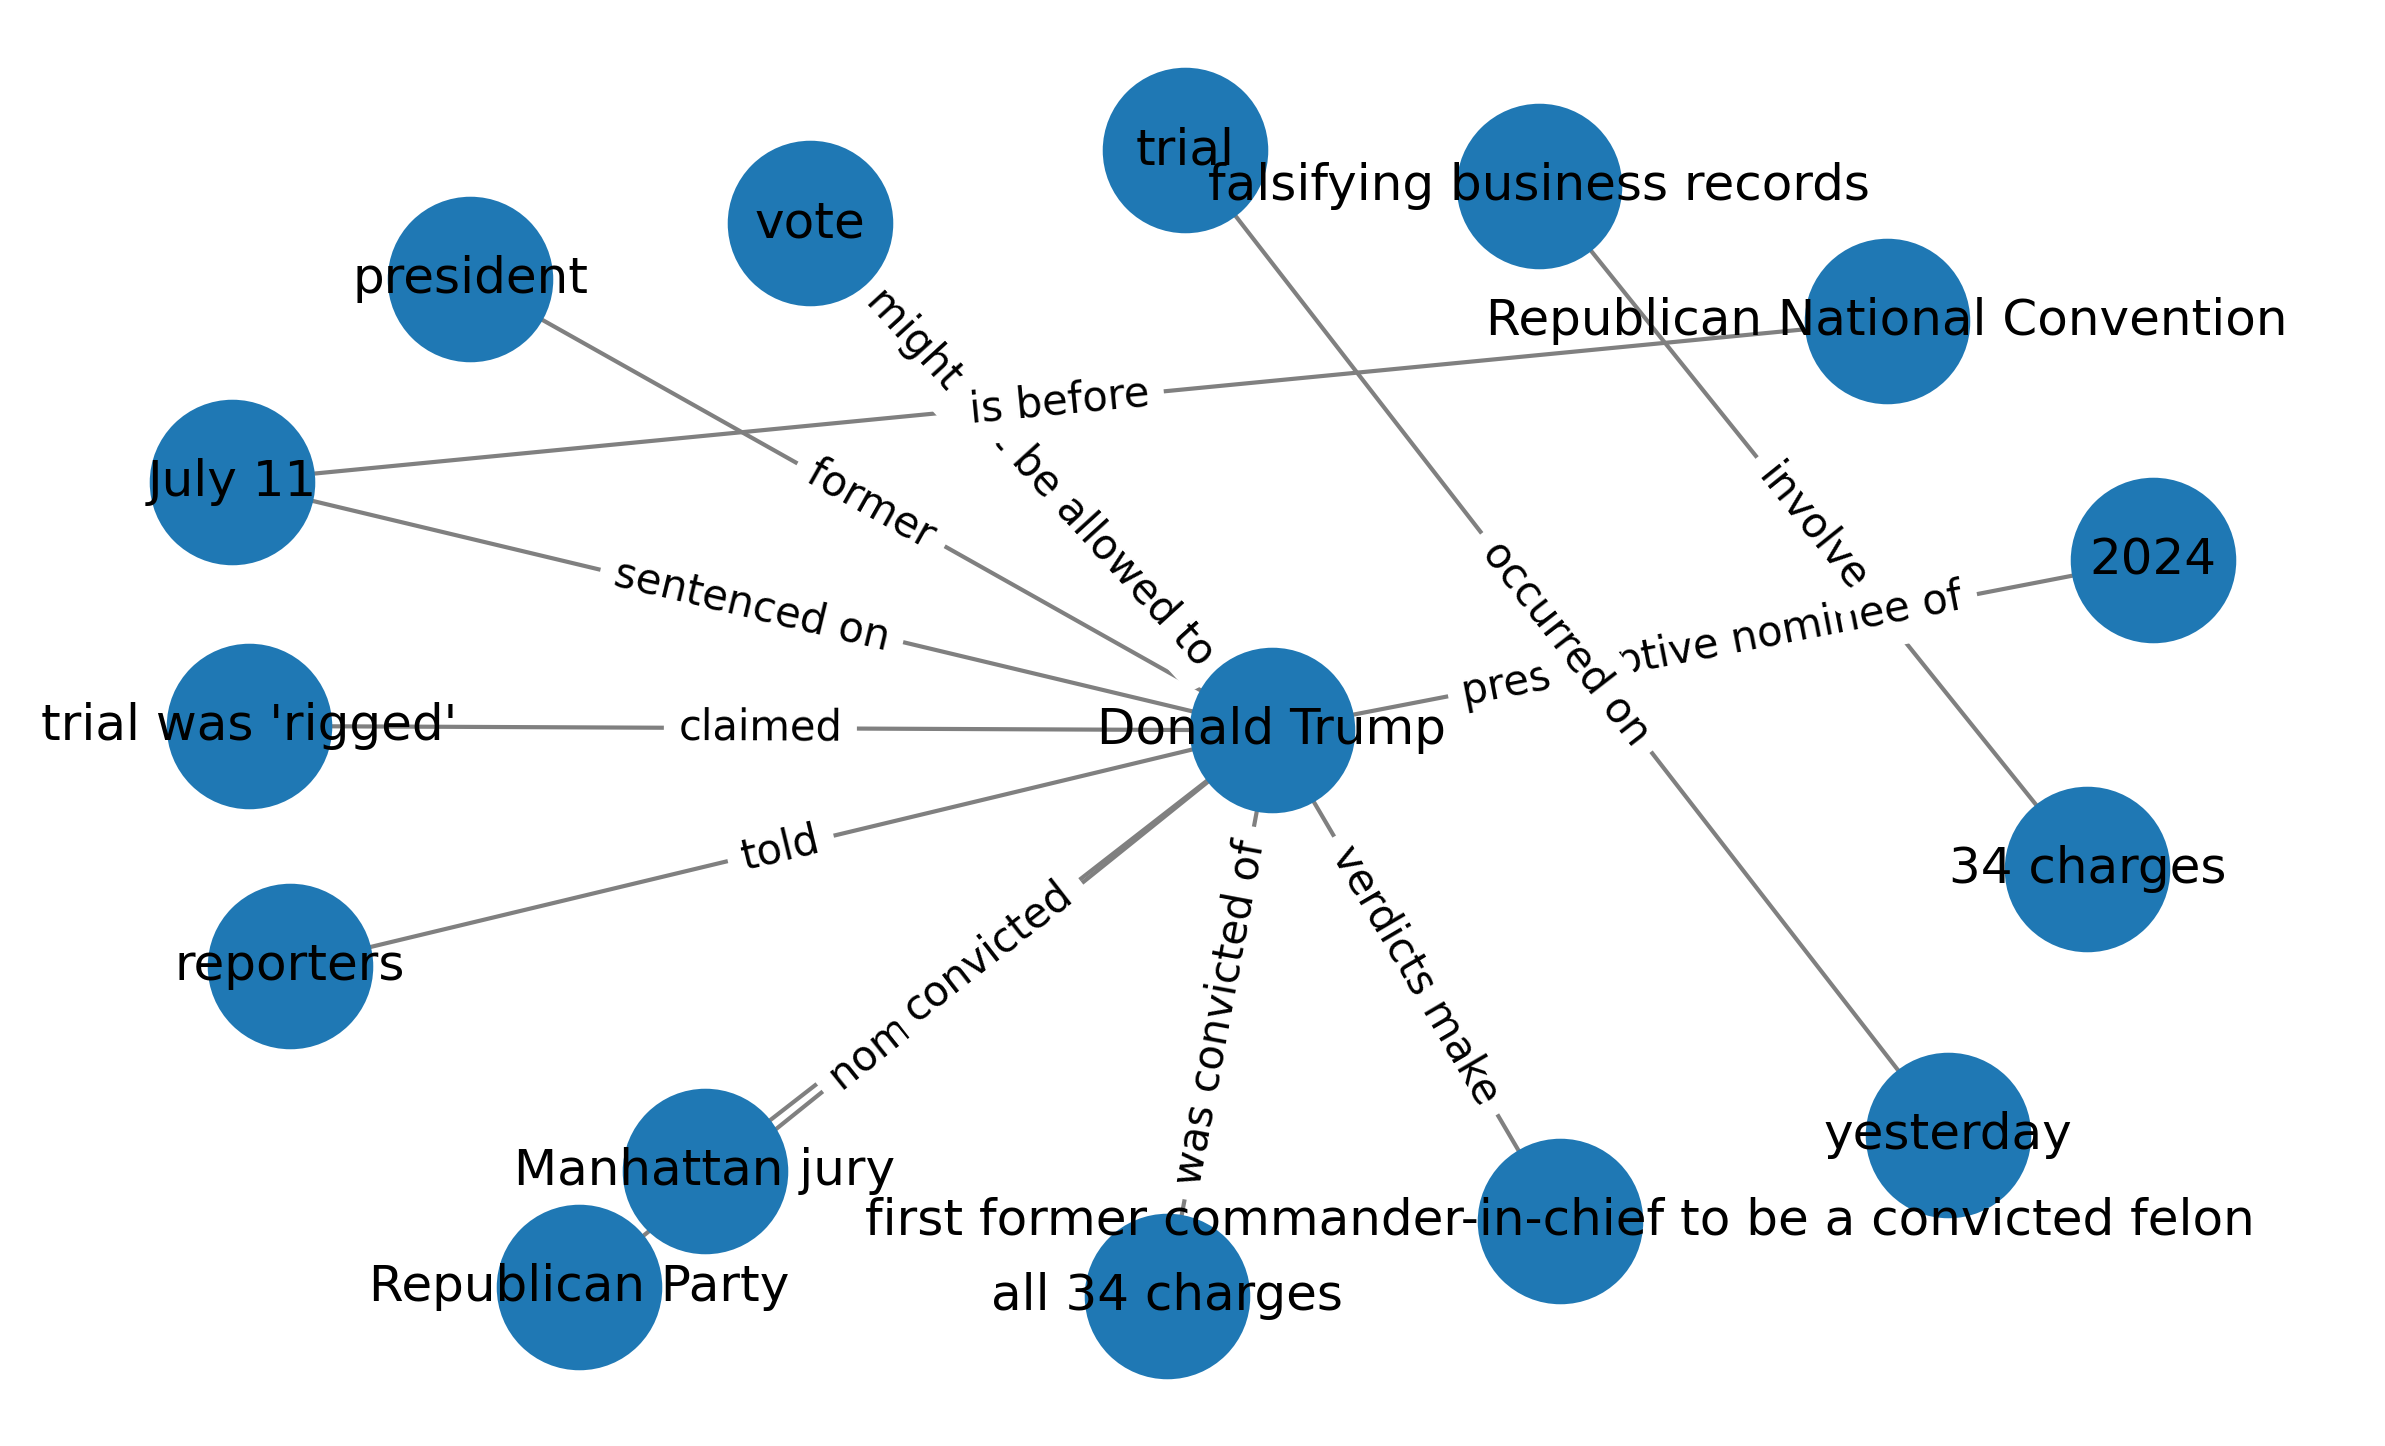

In [156]:
# Plot the updated knowledge graph
plot_graph(merged_kg)

In [157]:
import datetime
# Get the current datetime
current_datetime = datetime.datetime.now()

# Format the datetime as a string
formatted_datetime = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

# Create the title with the datetime
title_with_datetime = f"updated_knowledge_graph_{formatted_datetime}.json"

# Save the updated knowledge graph to a file
with open(f'saved_kg/{title_with_datetime}', 'w') as f:
    json.dump(merged_kg, f)


In [158]:
# Parse knowledge graph to extract relevant relations
question = "When will Donald Trump be sentenced?"
parsed_kg = parse_knowledge_graph(merged_kg, question)
print(parsed_kg)

{'List of triplets': [['Donald Trump', 'sentenced on', 'July 11']]}


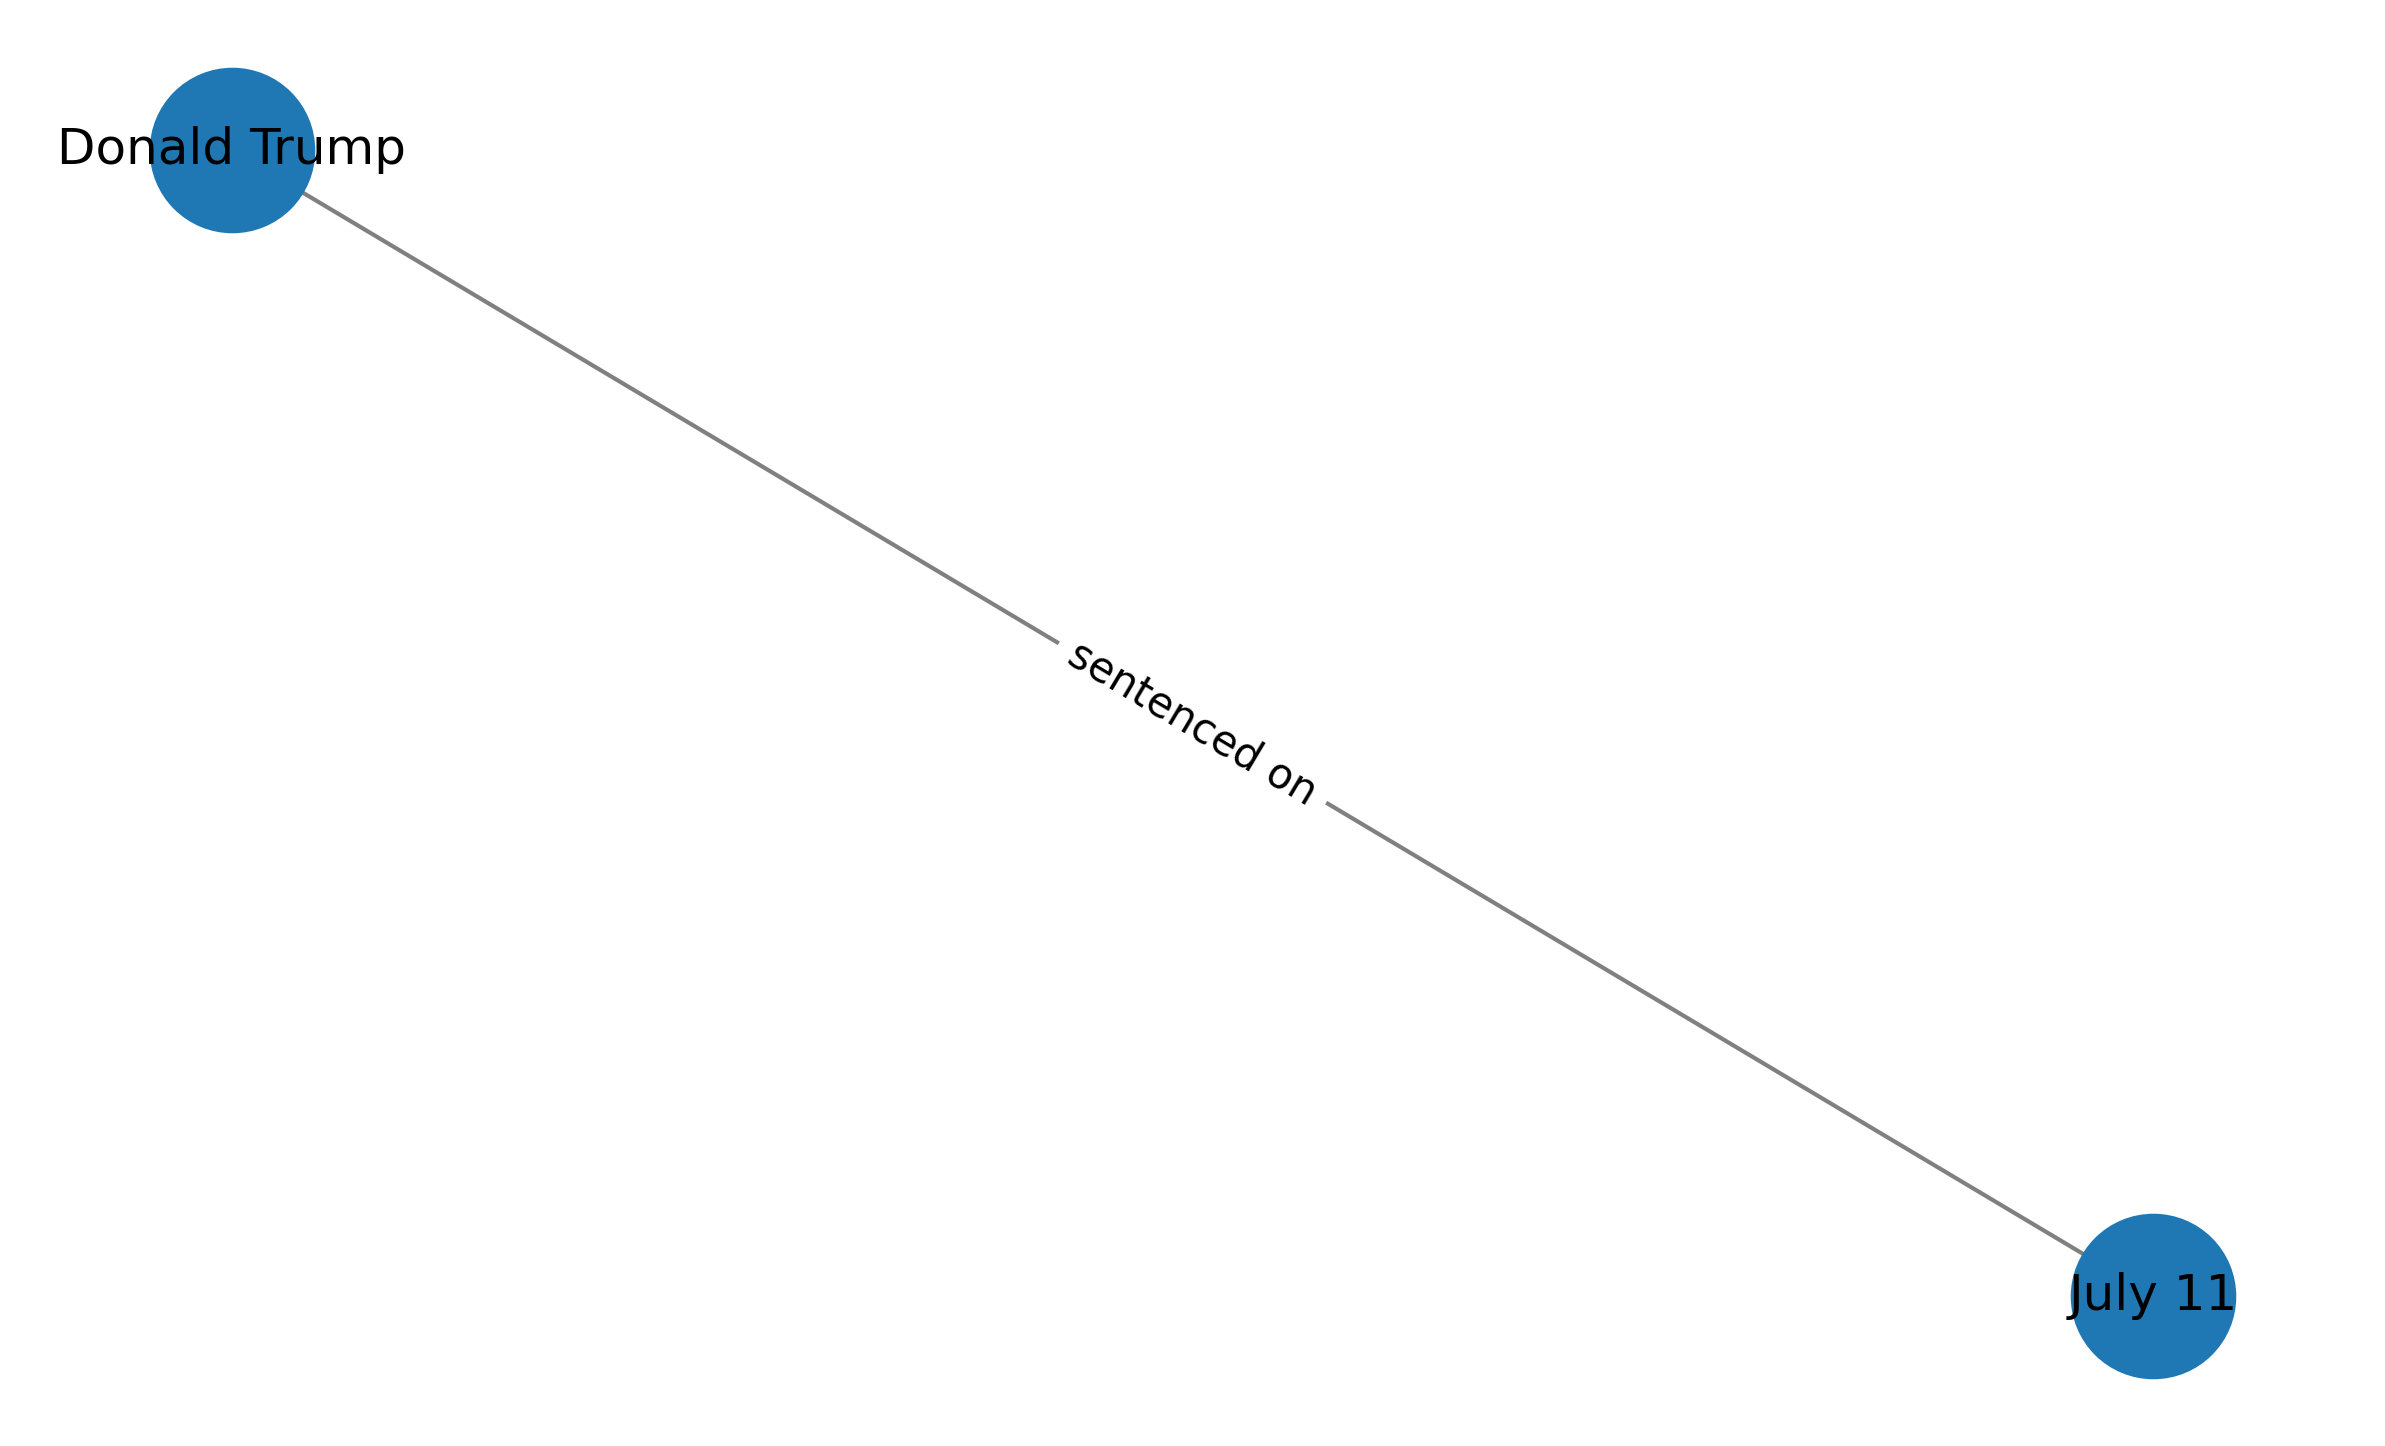

In [159]:
# Plot the parsed knowledge graph
plot_graph(parsed_kg)

In [160]:
# Generate a response to a question based on the parsed knowledge graph
response = chat(f'''Use the following knowledge graph to answer the following question. 
If you are unsure, output 'No Info'
Knowledge Graph: {parsed_kg['List of triplets']}''',
                    user_prompt = f'''Question: {question}''')

print('Response:', response)

Response: Donald Trump will be sentenced on July 11.


### Adding new data

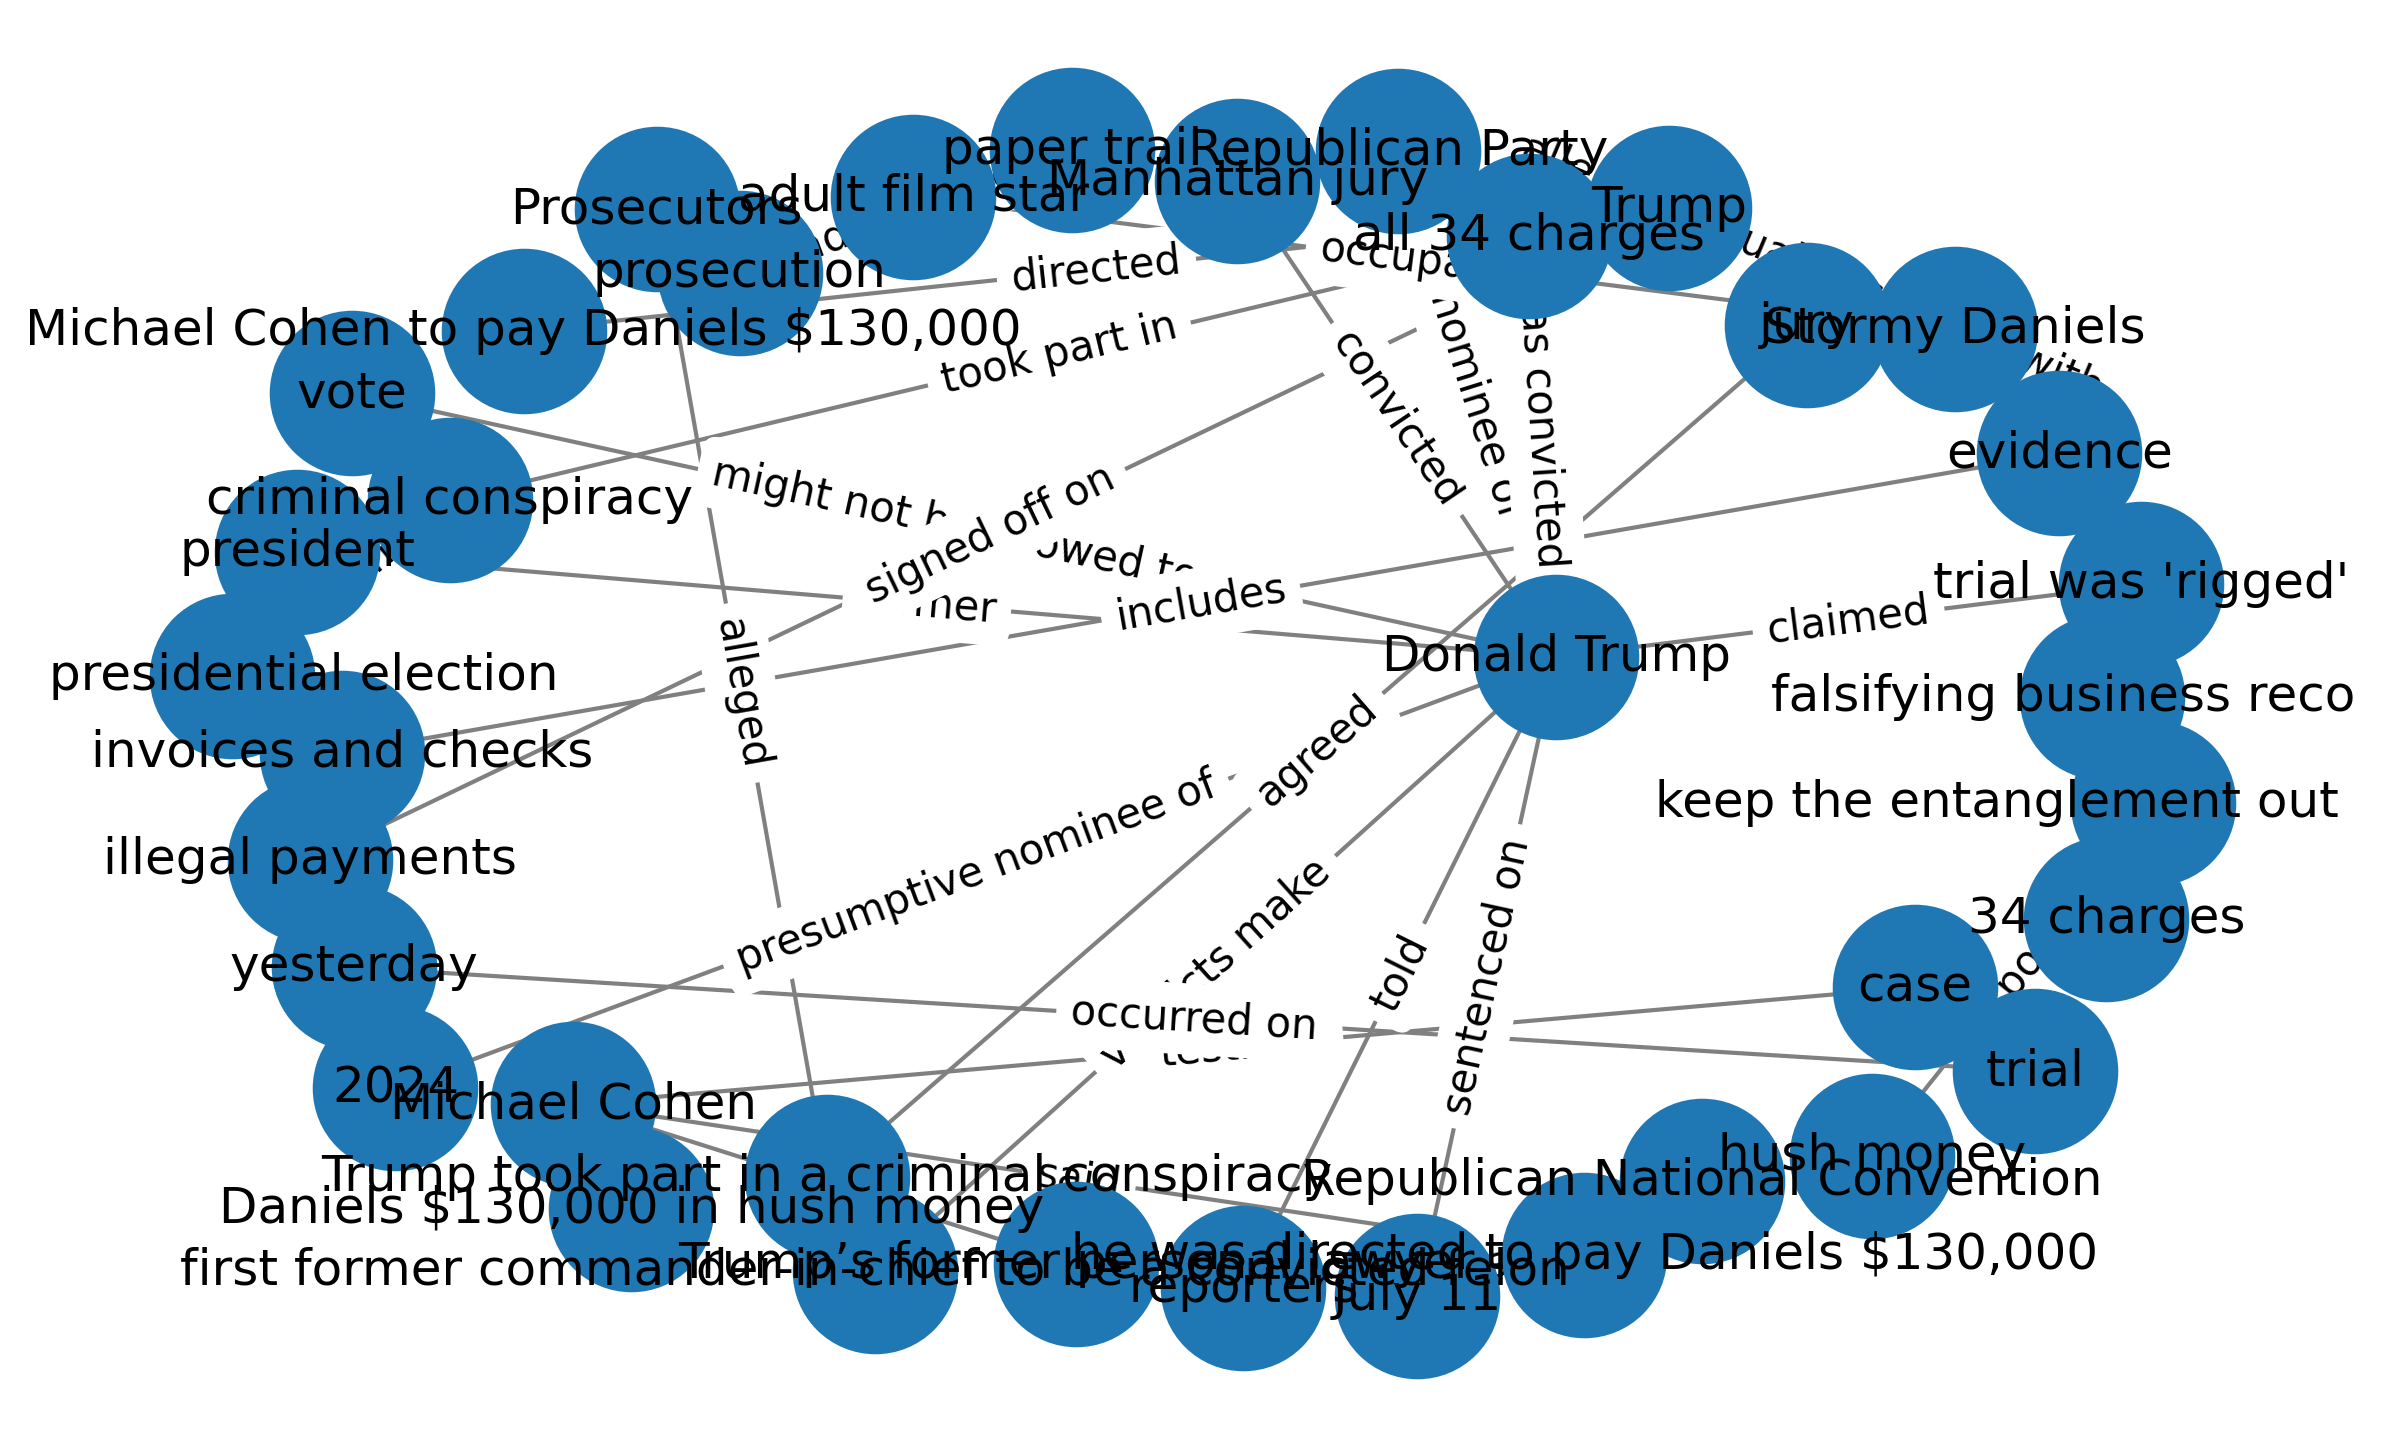

In [161]:
new_input = "What was Trump convicted of? Prosecutors alleged—and a jury has now agreed—that Trump took part in a criminal conspiracy to undermine the 2016 presidential election by paying off adult film star Stormy Daniels to keep quiet about their alleged sexual encounter. Central to the case was the testimony of Trump’s former personal lawyer, Michael Cohen, who said he was directed to pay Daniels $130,000 in hush money to keep the entanglement out of the press. The prosecution had a paper trail of evidence, including invoices and checks, that showed Trump signed off on the illegal payments."
new_kg = build_knowledge_graph(new_input)
merged_kg = merge_knowledge_graphs(merged_kg, new_kg)
plot_graph(merged_kg)

In [162]:
current_datetime = datetime.datetime.now()
formatted_datetime = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")
title_with_datetime = f"updated_knowledge_graph_{formatted_datetime}.json"
with open(f'saved_kg/{title_with_datetime}', 'w') as f:
    json.dump(merged_kg, f)

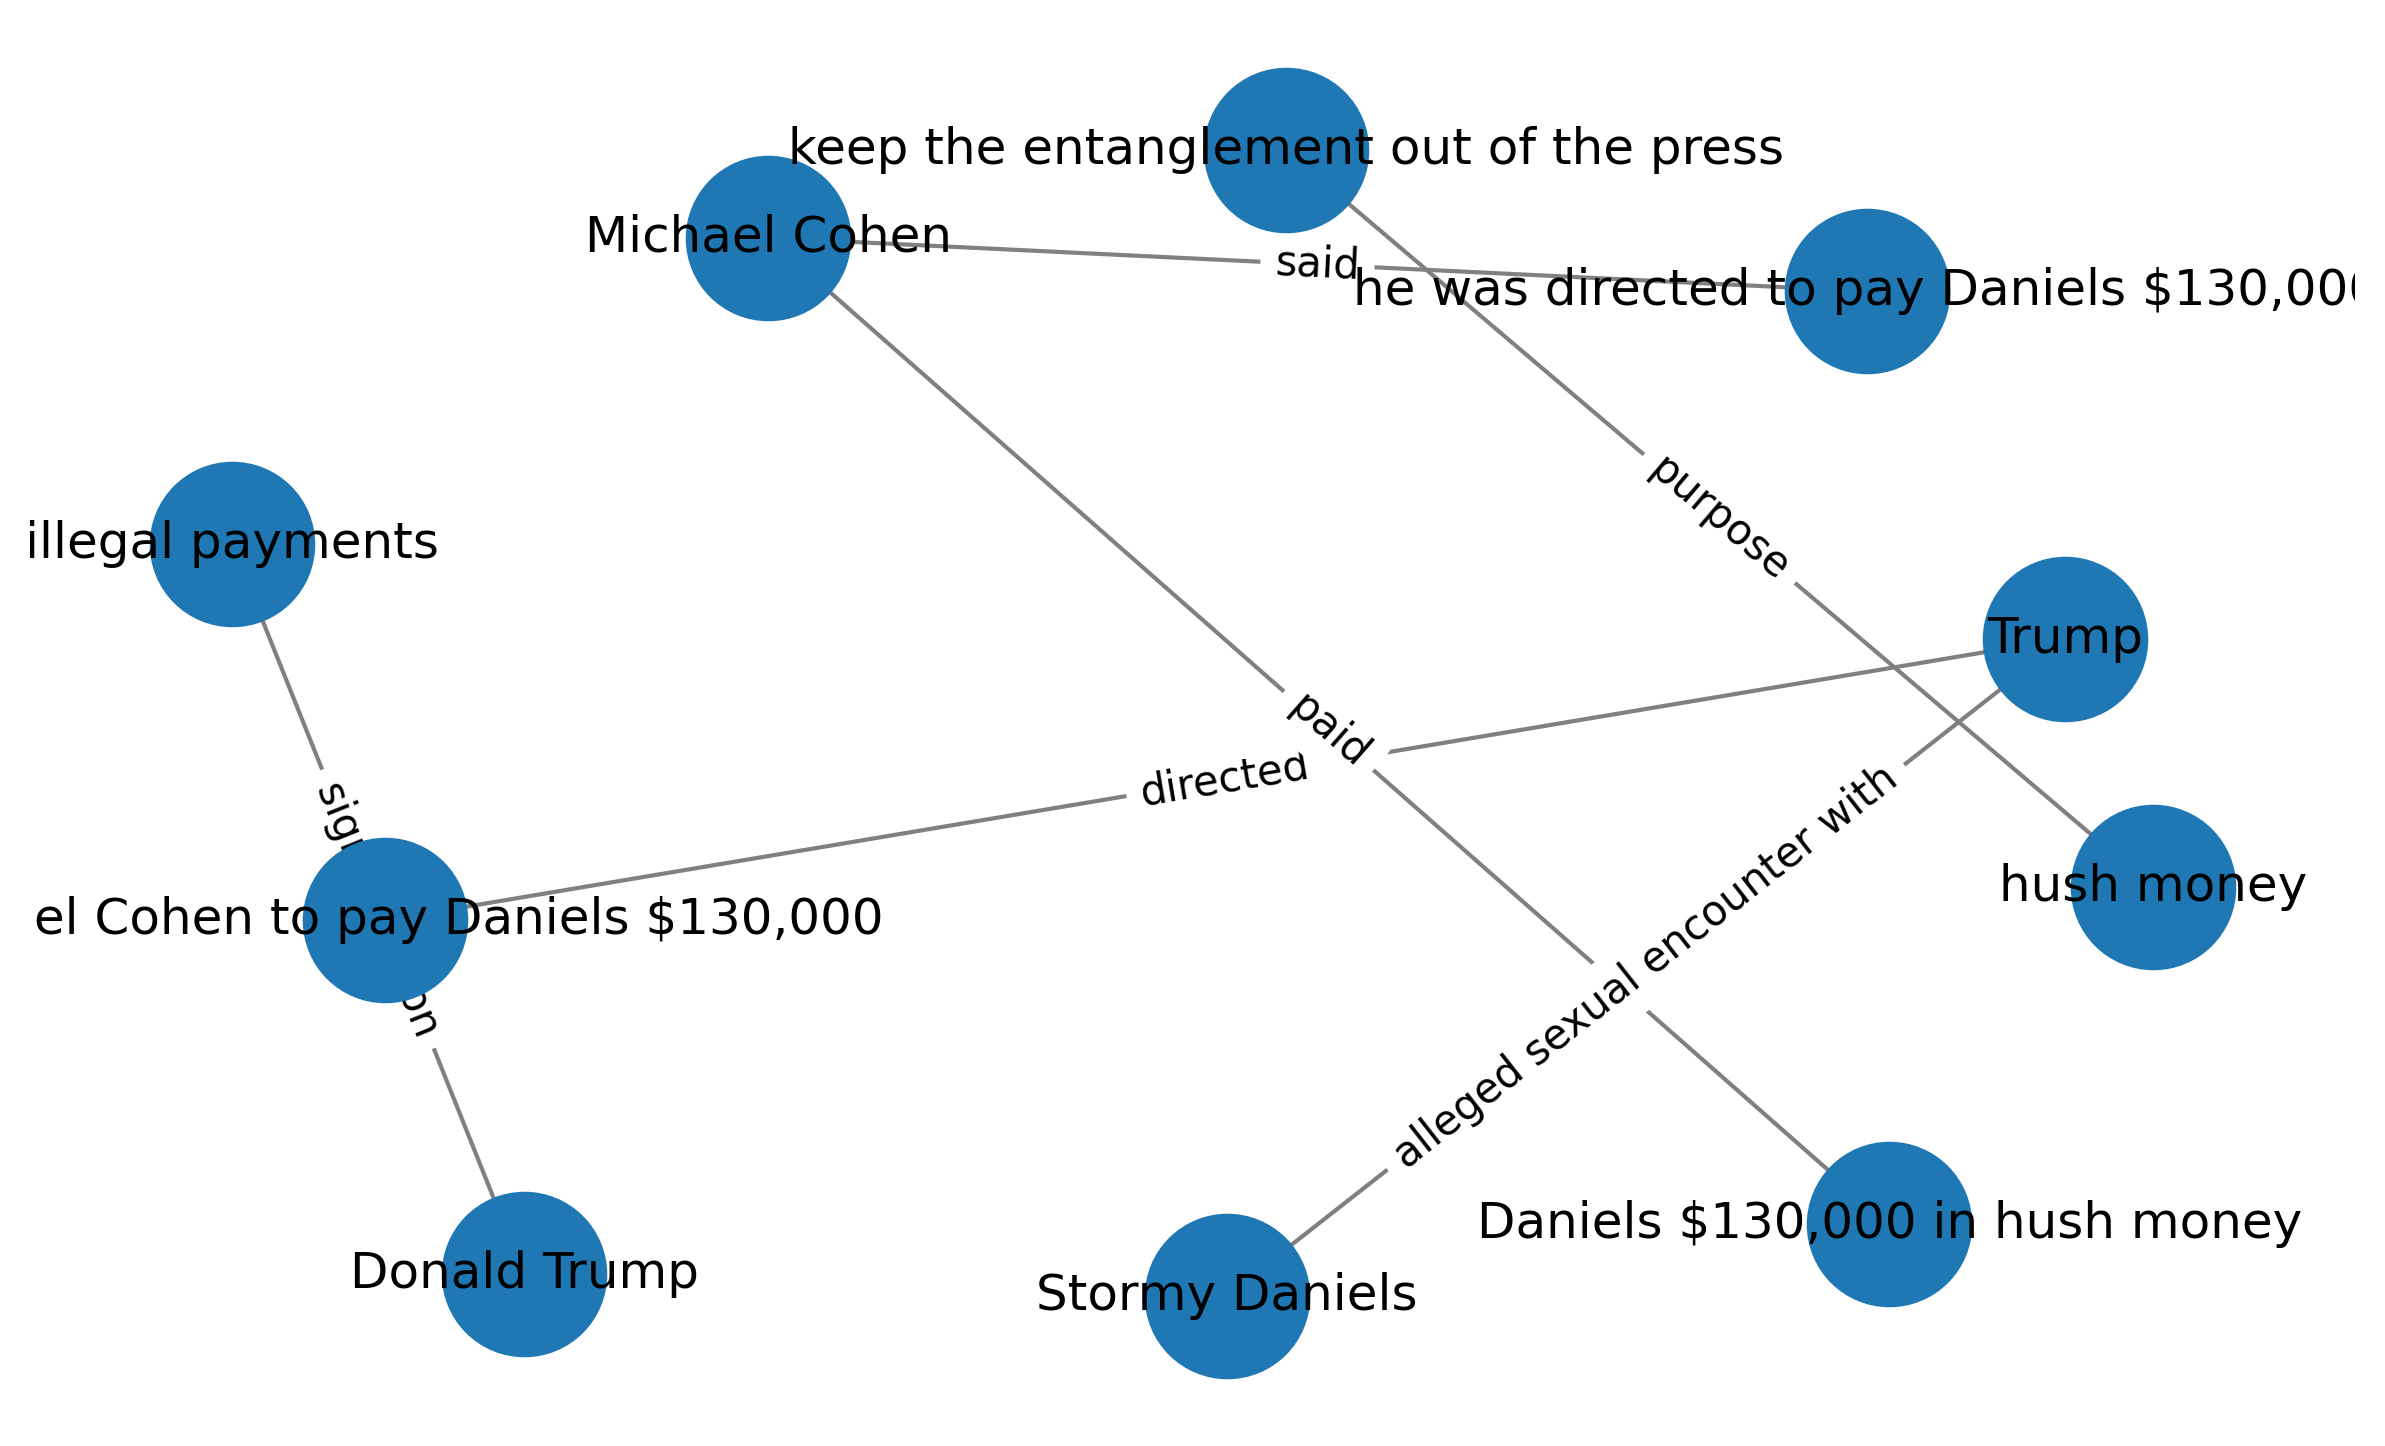

In [163]:
question = "Why did Trump pay Stormy Daniels?"
parsed_kg = parse_knowledge_graph(merged_kg, question)
plot_graph(parsed_kg)

In [164]:
response = chat(
    f'''Use the following knowledge graph to answer the following question. 
    If you are unsure, output 'No Info'
    Knowledge Graph: {parsed_kg['List of triplets']}''',
    user_prompt=f'''Question: {question}'''
)
print('Response:', response)

Response: Trump paid Stormy Daniels to keep the entanglement out of the press.


In [165]:
# new_input = """

# """
# new_kg = build_knowledge_graph(new_input)
# merged_kg = merge_knowledge_graphs(merged_kg, new_kg)
# plot_graph(merged_kg)

# current_datetime = datetime.datetime.now()
# formatted_datetime = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")
# title_with_datetime = f"updated_knowledge_graph_{formatted_datetime}.json"
# with open(f'saved_kg/{title_with_datetime}', 'w') as f:
#     json.dump(merged_kg, f)

# question = """

# """
# parsed_kg = parse_knowledge_graph(merged_kg, question)
# plot_graph(parsed_kg)

# response = chat(
#     f'''Use the following knowledge graph to answer the following question. 
#     If you are unsure, output 'No Info'
#     Knowledge Graph: {parsed_kg['List of triplets']}''',
#     user_prompt=f'''Question: {question}'''
# )
# print('Response:', response)

In [166]:
import matplotlib.pyplot as plt
import networkx as nx

def plot_graph(kg, parsed_kg, title="Knowledge Graph"):
    ''' Plots graph based on knowledge graph with highlighted relevant nodes and edges '''
    G = nx.DiGraph()
    
    # Extract all triplets and relevant triplets
    all_triplets = set(tuple(triplet) for triplet in kg['List of triplets'])
    relevant_triplets = set(tuple(triplet) for triplet in parsed_kg['List of triplets'])
    
    # Add all triplets to the graph
    G.add_edges_from((source, target, {'relation': relation, 'color': 'gray'}) for source, relation, target in all_triplets)
    
    # Highlight relevant triplets
    for source, relation, target in relevant_triplets:
        if G.has_edge(source, target):
            G[source][target]['color'] = 'blue'
            G.nodes[source]['color'] = 'red'
            G.nodes[target]['color'] = 'red'
    
    # Plot the graph
    pos = nx.spring_layout(G, k=3, seed=0)
    
    # Draw nodes and edges with different colors
    node_colors = [G.nodes[node].get('color', 'lightgray') for node in G.nodes()]
    edge_colors = [G[u][v]['color'] for u, v in G.edges()]

    plt.figure(figsize=(12, 8), dpi=300)
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=1500)
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors)
    nx.draw_networkx_labels(G, pos, font_size=12)
    
    edge_labels = nx.get_edge_attributes(G, 'relation')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

    plt.title(title)
    plt.axis('off')
    plt.show()

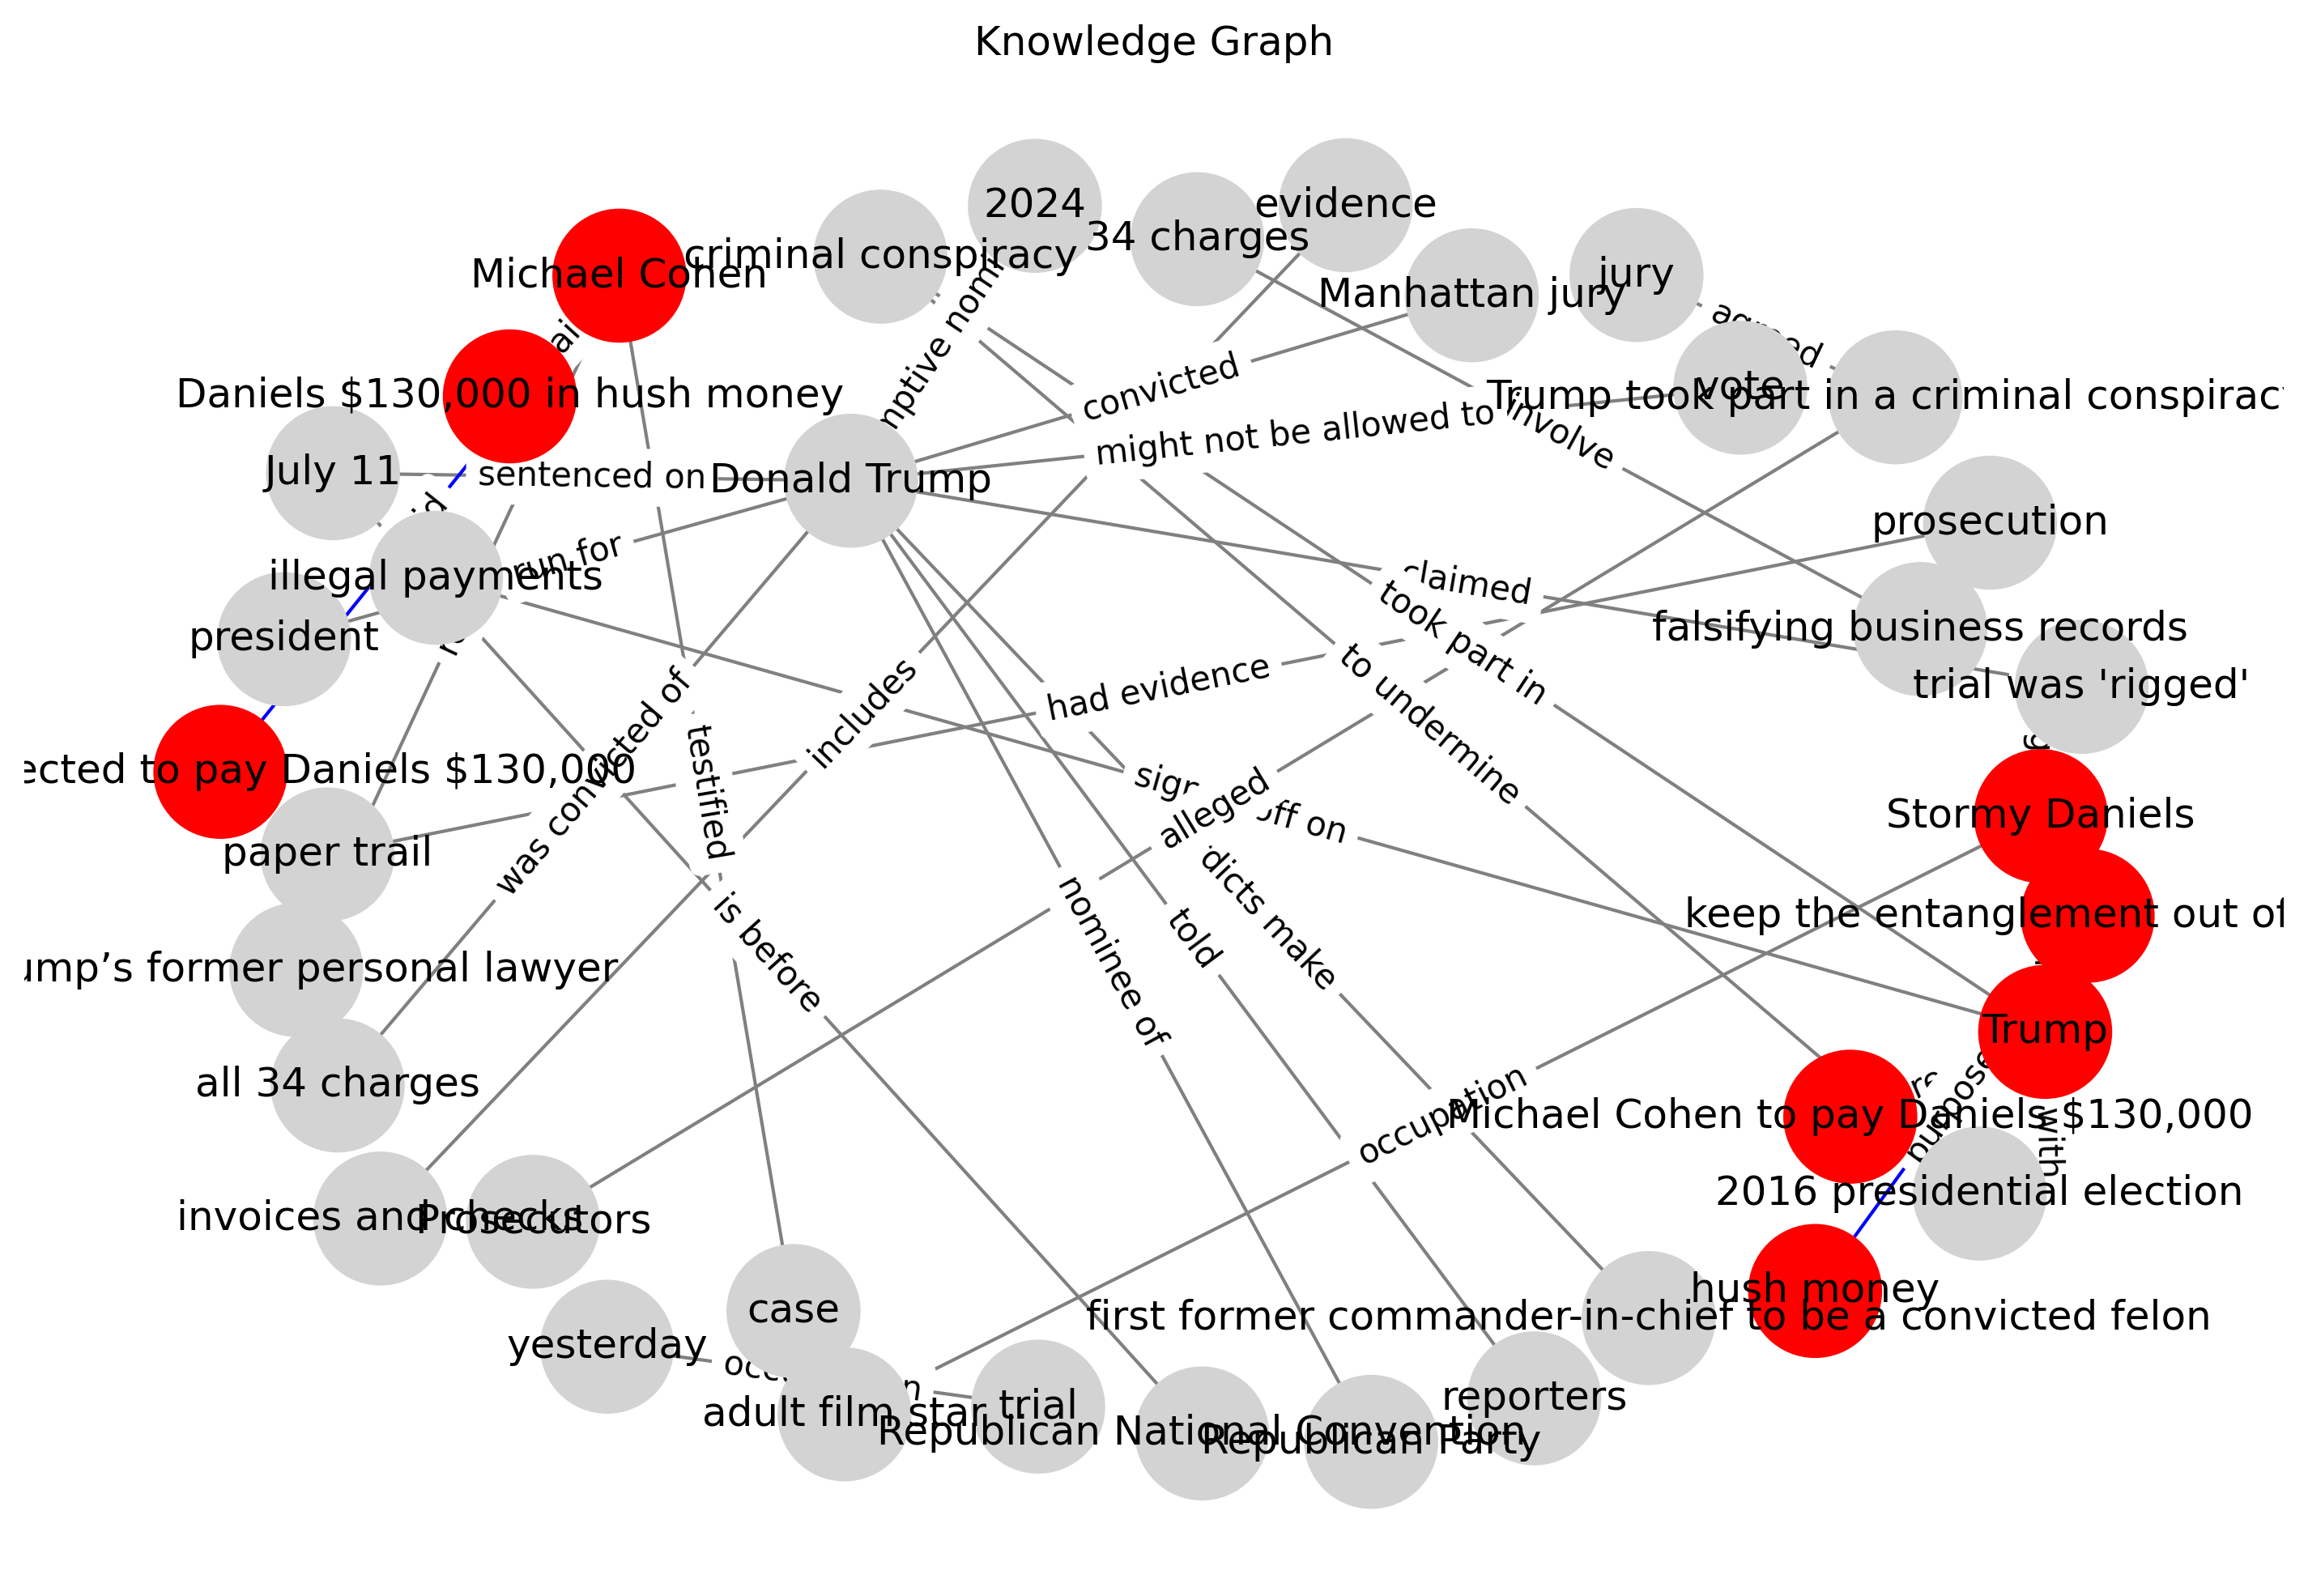

In [167]:
plot_graph(merged_kg, parsed_kg)

### Text-to-speech

In [174]:
load_dotenv()
xi_api_key = os.getenv("xi_api_key")
os.environ["ELEVEN_API_KEY"] = xi_api_key

In [183]:
def text_to_speech(text, voice_id, output_path):
    """
    Converts text to an audio file using the Eleven Labs API.
    """
    client = ElevenLabs(
    api_key=xi_api_key, # Defaults to ELEVEN_API_KEY
    )

    audio = client.generate(
        text=text, 
        voice=Voice(
            voice_id=voice_id,
            settings=VoiceSettings(stability=0.45, similarity_boost=0.75, style=0.05, use_speaker_boost=True)
        )
    )
    save(audio, output_path)

In [184]:
daniel_id = "g1jcQ5OAqJG32smac687"
text = "Hello world, my name is Daniel. I am a text-to-speech voice."
output_path = "audio_files/test.mp3"
text_to_speech(text, daniel_id, output_path)